In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import itertools

np.random.seed(42)
tf.random.set_seed(42)

2024-06-03 00:13:20.307586: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 00:13:20.328011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 00:13:20.328028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 00:13:20.328581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 00:13:20.332032: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [3]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [4]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [5]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('../output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.075, shuffle = False)

    return X_train, X_test, y_train, y_test

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
def build_model(input_shape, md_prm: dict):
    # model = Sequential()
    
    # model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))
    
    # model.add(LSTM(50, return_sequences=True))
    # model.add(Dropout(0.2))
    
    # model.add(LSTM(50))
    # model.add(Dropout(0.2))
    
    # model.add(Dense(1))
    
    # model.compile(optimizer='adam', loss='mape', metrics=[rmse])


    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(md_prm['dropout']))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(md_prm['dropout']))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return model

In [8]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

In [9]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [10]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=4):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [11]:
# n_steps: 5, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 16, epochs: 100

# n_steps_options = [5, 10]
# batch_size_options = [16, 32, 64]
# epochs_options = [100]
# lstm_units_options = [50, 100]
# activation_options = ['relu']
# dropout_options = [0.1, 0.2]
# num_layers_options = [1, 2]

n_steps_options     = [40]
batch_size_options  = [16]
epochs_options      = [100]
lstm_units_options  = [50]
activation_options  = ['relu']
dropout_options     = [0.15]
num_layers_options  = [2]

# learning_rate_options = [0.001, 0.01, 0.1]
# optimizer_options = ['adam', 'sgd', 'rmsprop']

variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
print(modified_lists)
# modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# Crear combinaciones de parámetros
model_params_combinations = list(itertools.product(
    n_steps_options     , 
    lstm_units_options, 
    activation_options, 
    dropout_options,
    num_layers_options,  # Incluido para múltiples capas LSTM
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

[['LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_4D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_3D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_2D'], ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D']]


In [12]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 10


In [13]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:
            df = load_data("./../input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units, activation, dropout, num_layers))

            print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)
            
            model_params = {
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers
            }

            input_shape = (X_train.shape[1], X_train.shape[2])

            print("Input shape: ", input_shape)

            model = build_model(input_shape, model_params)
            print(model.summary())

            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

            y_pred      = model.predict(X_test)
            rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
            std_dev     = np.std(y_test)

            print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

            diff = rmse_score - std_dev + abs(np.std(y_pred) - std_dev)

            result = {
                'n_steps'   : n_steps,
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers,
                'batch_size': batch_size,
                'epochs'    : epochs,
                'rmse'      : rmse_score,
                'std_dev'   : std_dev,
                'diff'      : diff,
                'predictions': y_pred,
                'true_values': y_test,
                'feature_list': var_options
            }

            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['diff'])

            print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
            print("Completed Iteration {}/{}".format(i, n_iterations))

        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1

    return top_results

In [14]:
top_results = run_model_iterations()


Iteration 1/10
Params: n_steps: 40, lstm_units: 50, activation: relu, dropout: 0.15, num_layers: 2
Variables used: ['LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Features utilizados: Index(['LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D',
       'ACU_2D'],
      dtype='object')
Input shape:  (40, 9)


2024-06-03 00:13:21.535041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 00:13:21.554441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 00:13:21.554576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 100)           44000     
                                                                 
 dropout (Dropout)           (None, 40, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 124501 (486.33 KB)
Trainable params: 124501 (486.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100

2024-06-03 00:13:24.512404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-03 00:13:25.102323: I external/local_xla/xla/service/service.cc:168] XLA service 0x76e53fc293f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 00:13:25.102335: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-03 00:13:25.105118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717391605.153607  211206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


287/287 [==============================] - 6s 10ms/step - loss: 0.0018 - rmse: 0.0410 - val_loss: 0.0012 - val_rmse: 0.0313
Epoch 2/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0014 - rmse: 0.0357 - val_loss: 0.0013 - val_rmse: 0.0326
Epoch 3/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0012 - val_rmse: 0.0310
Epoch 4/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0012 - val_rmse: 0.0316
Epoch 5/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0012 - val_rmse: 0.0311
Epoch 6/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0012 - val_rmse: 0.0315
Epoch 7/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0013 - val_rmse: 0.0327
Epoch 8/100
287/287 [==============================] - 3s 9ms/step

In [15]:
top_results = sorted(top_results, key=lambda x: x['diff'])

Top 1 
RMSE: 0.027699, STD_DEV: 0.025617, DIFF: 0.017621
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


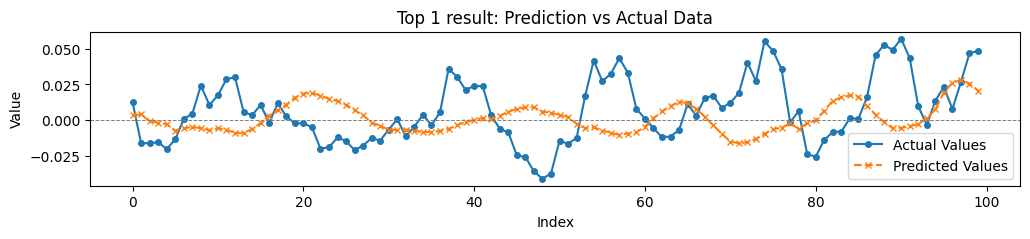

Top 2 
RMSE: 0.026306, STD_DEV: 0.025617, DIFF: 0.018568
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


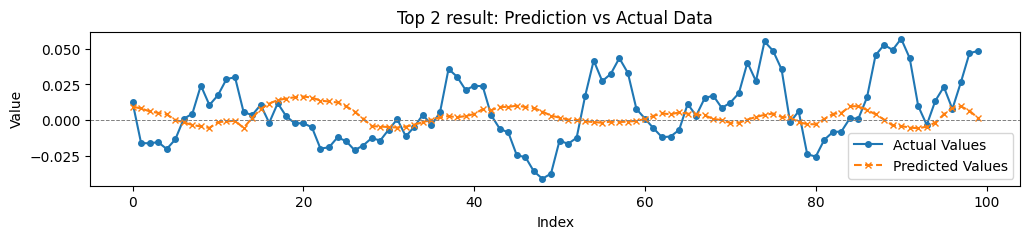

Top 3 
RMSE: 0.026928, STD_DEV: 0.025617, DIFF: 0.019629
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


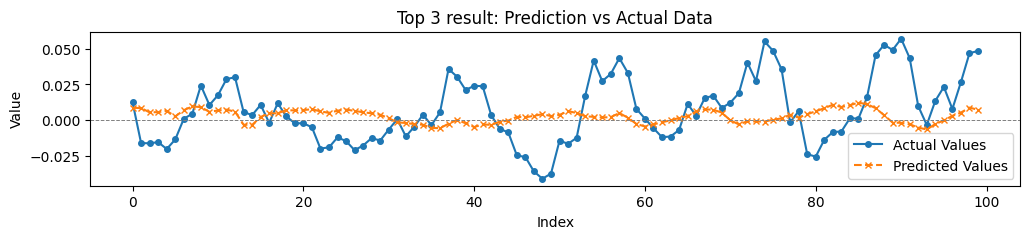

Top 4 
RMSE: 0.026655, STD_DEV: 0.025617, DIFF: 0.019776
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_3D', 'ACU_2D']


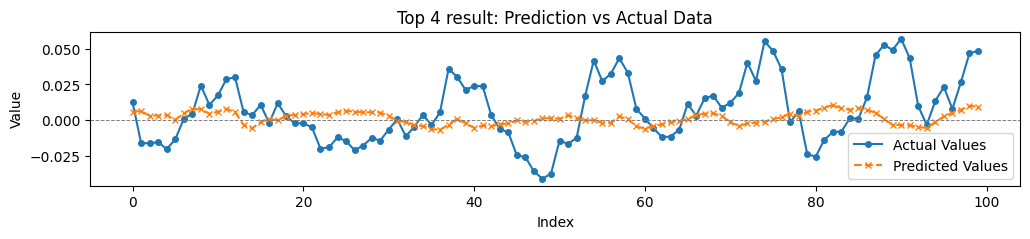

Top 5 
RMSE: 0.025531, STD_DEV: 0.025617, DIFF: 0.020203
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D']


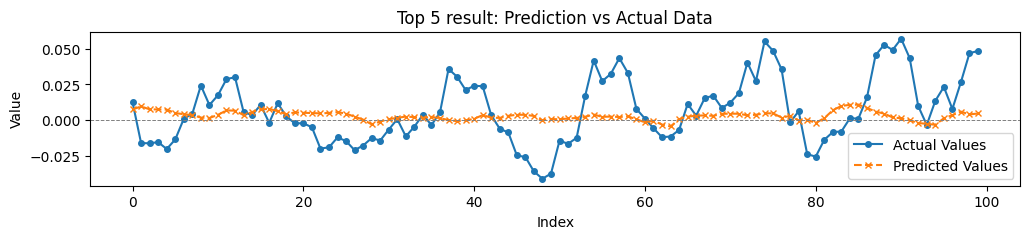

Top 6 
RMSE: 0.026296, STD_DEV: 0.025617, DIFF: 0.020572
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


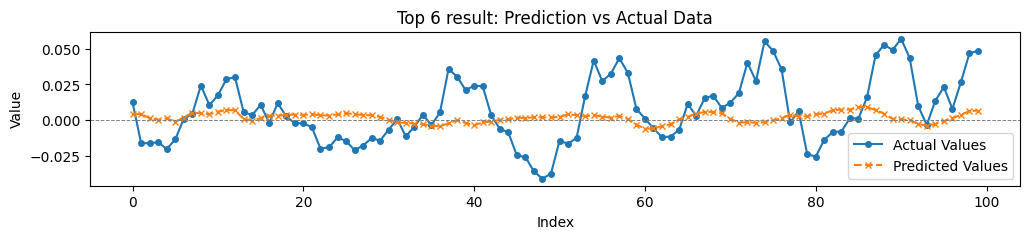

Top 7 
RMSE: 0.025982, STD_DEV: 0.025617, DIFF: 0.020668
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


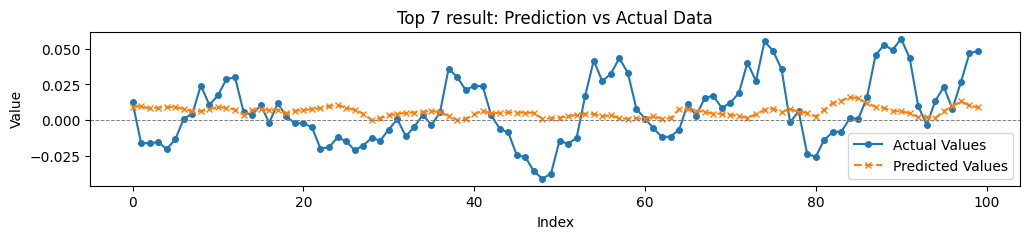

Top 8 
RMSE: 0.026776, STD_DEV: 0.025617, DIFF: 0.020861
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_2D']


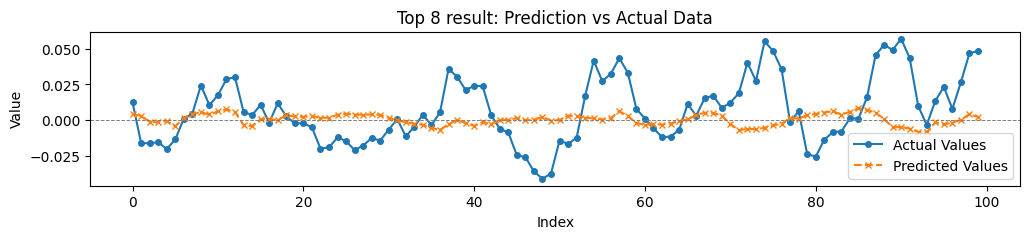

Top 9 
RMSE: 0.026039, STD_DEV: 0.025617, DIFF: 0.020948
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']


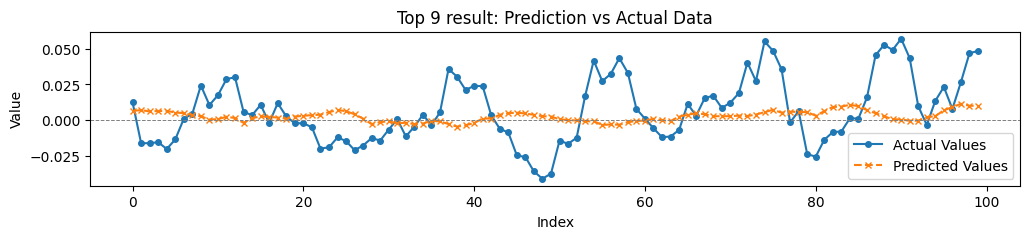

Top 10 
RMSE: 0.026480, STD_DEV: 0.025617, DIFF: 0.021382
n_steps: 40, rnn_units: 50, activation: relu, dropout: 0.15, batch_size: 16, epochs: 100
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_4D', 'ACU_3D', 'ACU_2D']


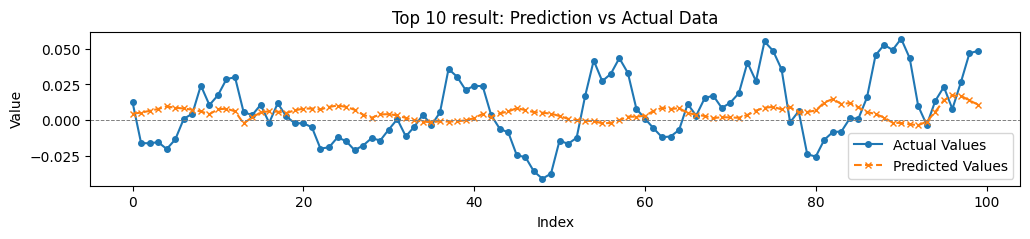

In [16]:
for i,result in enumerate(top_results,1):
    print(f"Top {i} ")
    print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(result['rmse'], result['std_dev'], result['diff']))
    print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    print("Feature list: ", result['feature_list'])
    plot_predictions(result['true_values'], result['predictions'], 100, title=f"Top {i} result: Prediction vs Actual Data")
    

In [17]:
# export the best result predictions and true values to a csv file
best_result = top_3_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('./../output/lstm_best_result.csv', index=False)

NameError: name 'top_3_results' is not defined